**Space X Falcon 9 First Stage Landing Prediction**

**Web scraping Falcon 9 and Falcon Heavy Launches Records from Wikipedia**

In this lab, you will be performing web scraping to collect Falcon 9 historical launch records from a Wikipedia page titled List of Falcon 9 and Falcon Heavy launches

https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches

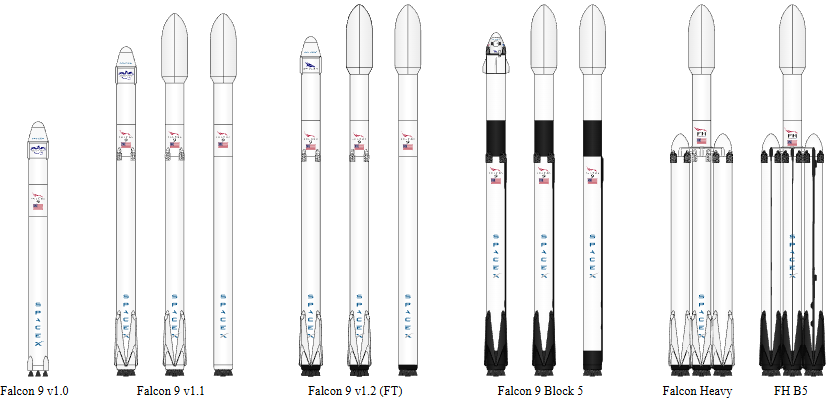

The launch records are stored in a HTML table on the wikipedia page.

Objectives

- Web scrap Falcon 9 launch records with BeautifulSoup:

- Extract a Falcon 9 launch records HTML table from Wikipedia
- Parse the table and convert it into a Pandas data frame

In [1]:
import sys
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

We will provide some helper functions for you to process web scraped HTML table

In [2]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()

    colunm_name = ' '.join(row.contents)

    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name

To keep the lab tasks consistent, you will be asked to scrape the data from a snapshot of the List of Falcon 9 and Falcon Heavy launches Wikipage updated on 9th June 2021

In [3]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/91.0.4472.124 Safari/537.36"
}

Next, request the HTML page from the above URL and get a response object

**TASK 1: Request the Falcon9 Launch Wiki page from its URL**

First, let's perform an HTTP GET method to request the Falcon9 Launch HTML page, as an HTTP response.

In [4]:
# use requests.get() method with the provided static_url and headers
# assign the response to a object
response = requests.get(static_url, headers=headers)

Create a BeautifulSoup object from the HTML response

In [5]:
# Use BeautifulSoup() to create a BeautifulSoup object from a response text content
soup = BeautifulSoup(response.text, 'html.parser')

In [6]:
# Print the page title to verify if the BeautifulSoup object was created properly
# Use soup.title attribute
print(soup.title)


<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>


**TASK 2: Extract all column/variable names from the HTML table header**

Next, we want to collect all relevant column names from the HTML table header

Let's try to find all tables on the wiki page first. If you need to refresh your memory about BeautifulSoup, please check the external reference link towards the end of this lab

In [7]:
# Use the find_all function in the BeautifulSoup object, with element type `table`
# Assign the result to a list called `html_tables`
html_tables = soup.find_all('table')

Starting from the third table is our target table contains the actual launch records.

In [8]:
# Let's print the third table and check its content
first_launch_table = html_tables[2]
print(first_launch_table)

<table class="wikitable plainrowheaders collapsible" style="width: 100%;">
<tbody><tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11"><span class="cite-bracket">[</span>b<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12"><span class="cite-bracket">[</span>c<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 

You should able to see the columns names embedded in the table header elements < th >

Next, we just need to iterate through the <th> elements and apply the provided extract_column_from_header() to extract column name one by one

In [9]:
column_names = []

# Apply find_all() function with `th` element on first_launch_table
# Iterate each th element and apply the provided extract_column_from_header() to get a column name
# Append the Non-empty column name (`if name is not None and len(name) > 0`) into a list called column_names
for row in first_launch_table.find_all('th'):
    name = extract_column_from_header(row)
    if name is not None and len(name) > 0:
        column_names.append(name)

Check the extracted column names

In [10]:
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


**TASK 3: Create a data frame by parsing the launch HTML tables**

We will create an empty dictionary with keys from the extracted column names in the previous task. Later, this dictionary will be converted into a Pandas dataframe

In [11]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

Next, we just need to fill up the launch_dict with launch records extracted from table rows.

Usually, HTML tables in Wiki pages are likely to contain unexpected annotations and other types of noises, such as reference links B0004.1[8], missing values N/A [e], inconsistent formatting, etc.

To simplify the parsing process, we have provided an incomplete code snippet below to help you to fill up the launch_dict. Please complete the following code snippet with TODOs or you can choose to write your own logic to parse all launch tables:

In [12]:
extracted_row = 0
#Extract each table
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element
        row=rows.find_all('td')
        #if it is number save cells in a dictonary
        if flag:
            extracted_row += 1
            # Flight Number value
            # TODO: Append the flight_number into launch_dict with key `Flight No.`
            launch_dict['Flight No.'].append(flight_number)
            #print(flight_number)
            datatimelist=date_time(row[0])

            # Date value
            # TODO: Append the date into launch_dict with key `Date`
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            #print(date)

            # Time value
            # TODO: Append the time into launch_dict with key `Time`
            time = datatimelist[1]
            launch_dict['Time'].append(time)
            #print(time)

            # Booster version
            # TODO: Append the bv into launch_dict with key `Version Booster`
            bv=booster_version(row[1])
            if not(bv):
                if row[1].a: # Check if <a> tag exists
                    bv=row[1].a.string
                else:
                    bv="N/A" # Fallback if no <a> tag either
            launch_dict['Version Booster'].append(bv)
            #print(bv)

            # Launch Site
            # TODO: Append the bv into launch_dict with key `Launch Site`
            launch_site = row[2].a.string if row[2].a else "N/A"
            launch_dict['Launch site'].append(launch_site)
            #print(launch_site)

            # Payload
            # TODO: Append the payload into launch_dict with key `Payload`
            payload = row[3].a.string if row[3].a else "N/A"
            launch_dict['Payload'].append(payload)
            #print(payload)

            # Payload Mass
            # TODO: Append the payload_mass into launch_dict with key `Payload mass`
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)
            #print(payload)

            # Orbit
            # TODO: Append the orbit into launch_dict with key `Orbit`
            orbit = row[5].a.string if row[5].a else "N/A"
            launch_dict['Orbit'].append(orbit)
            #print(orbit)

            # Customer
            # TODO: Append the customer into launch_dict with key `Customer`
            customer_tag = row[6].find('a') # Find the first <a> tag within the td cell
            if customer_tag:
                customer = customer_tag.string
            else:
                # If no <a> tag is found, get the text content of the td cell and strip it.
                # This handles cases where customer name is plain text or within other tags.
                customer = row[6].text.strip()
                if not customer: # If it's still empty, assign "N/A"
                    customer = "N/A"
            launch_dict['Customer'].append(customer)
            #print(customer)

            # Launch outcome
            # TODO: Append the launch_outcome into launch_dict with key `Launch outcome`
            launch_outcome = list(row[7].strings)[0].strip() if list(row[7].strings) else "N/A"
            launch_dict['Launch outcome'].append(launch_outcome)
            #print(launch_outcome)

            # Booster landing
            # TODO: Append the launch_outcome into launch_dict with key `Booster landing`
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)
            #print(booster_landing)

After you have fill in the parsed launch record values into launch_dict, you can create a dataframe from it.

In [13]:
df= pd.DataFrame({ key:pd.Series(value) for key, value in launch_dict.items() })

We can now export it to a CSV for the next section, but to make the answers consistent and in case you have difficulties finishing this lab.

Following labs will be using a provided dataset to make each lab independent.

df.to_csv('spacex_web_scraped.csv', index=False)